# Demo (Tag Prediction)

Maybe valence/arousal/dominance values are bogus, attempting to predict tags instead

## Load Vectorizer

In [1]:
VOCAB_SIZE = 100000

In [2]:
def _count_generator(reader):
    b = reader(1024 * 1024)
    while b:
        yield b
        b = reader(1024 * 1024)

def num_lines(path):
    with open(path, 'rb') as fp:
        c_generator = _count_generator(fp.raw.read)
        # count each \n
        count = sum(buffer.count(b'\n') for buffer in c_generator)
        return count + 1

# Code from https://fasttext.cc/docs/en/english-vectors.html
# Modified to use a limited vocabulary size and have a progress bar
import io
from tqdm import tqdm as tqdm
import numpy as np

def load_vectors(fname):
    # lines = num_lines(fname)
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    # for line in tqdm(fin, total=lines):
    for idx, line in tqdm(enumerate(fin), total=VOCAB_SIZE):
        if idx >= VOCAB_SIZE:
            break
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])) + [0, 0])
    return data

In [3]:
vectorizer = load_vectors('wiki-news-300d-1M-subword-fasttext/wiki-news-300d-1M-subword.vec')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 28637.58it/s]


In [4]:
def vectorize(word) -> np.ndarray:
    if word == '':  # If this is a pad token
        return np.array([0] * 301 + [1], dtype=np.float64)
    if word in vectorizer:  # If this word is in our vocabulary
        return vectorizer[word]
    return np.array([0] * 300 + [1, 0], dtype=np.float64)  # Unknown token

## Load Data

In [5]:
import pandas as pd
data = pd.read_csv('out.csv')
data

,Unnamed: 0,lastfm_url,track,artist,seeds,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,mbid,spotify_id,genre,Lyric,language
0,1,https://www.last.fm/music/metallica/_/st.%2banger,St. Anger,Metallica,['aggressive'],8,3.710000,5.833000,5.427250,727a2529-7ee8-4860-aef6-7959884895cb,3fOc9x06lKJBhz435mInlH,metal,Saint Anger 'round my neck\nSaint Anger 'round...,en
1,3,https://www.last.fm/music/m.i.a./_/bamboo%2bbanga,Bamboo Banga,M.I.A.,"['aggressive', 'fun', 'sexy', 'energetic']",13,6.555071,5.537214,5.691357,99dd2c8c-e7c1-413e-8ea4-4497a00ffa18,6tqFC1DIOphJkCwrjVzPmg,hip-hop,"Road runner, road runner\nGoing hundred mile p...",en
2,5,https://www.last.fm/music/drowning%2bpool/_/st...,Step Up,Drowning Pool,['aggressive'],9,2.971389,5.537500,4.726389,49e7b4d2-3772-4301-ba25-3cc46ceb342e,4Q1w4Ryyi8KNxxaFlOQClK,metal,Come!\n\nIf our own lives aren’t directly affe...,en
3,11,https://www.last.fm/music/kanye%2bwest/_/feedback,Feedback,Kanye West,['aggressive'],1,3.080000,5.870000,5.490000,NaN,49fT6owWuknekShh9utsjv,hip-hop,"Ayy, y'all heard about the good news?\nY'all s...",en
4,13,https://www.last.fm/music/deftones/_/7%2bwords,7 Words,Deftones,"['aggressive', 'angry']",10,3.807121,5.473939,4.729091,1a826083-5585-445f-a708-415dc90aa050,6DoXuH326aAYEN8CnlLmhP,nu metal,"I'll never be the same, breaking decency\nDon'...",en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16792,229432,https://www.last.fm/music/noblegases/_/xenon,Xenon,NobleGases,['noble'],2,6.160000,3.695000,6.130000,NaN,1AePjgLLtzF0abbfcgYdLI,chill,You're floating out astray\nThis cold and life...,en
16793,229435,https://www.last.fm/music/kurt%2bvile/_/wild%2...,Wild Imagination,Kurt Vile,['transparent'],2,6.925000,4.975000,6.190000,NaN,1Gn0oYQiQHp7KF4DcR2g4t,NaN,I'm looking at you\nBut It's only a picture so...,en
16794,229436,https://www.last.fm/music/portugal.%2bthe%2bma...,Oh Lord,Portugal. The Man,['transparent'],1,5.370000,3.450000,5.330000,7ea228f9-16d0-474d-8c51-5a1a9810ddde,6YG8cjbrjhDhlYMiQnibUD,indie,\n\n\nWhere do I fit in\nI am waiting here for...,en
16795,229443,https://www.last.fm/music/porcelain%2band%2bth...,Transparent,Porcelain and The Tramps,['transparent'],3,6.613333,4.633333,5.773333,NaN,NaN,industrial,Wish I were transparent\nYou could see right t...,en


## Preprocess Lyrics

In [6]:
data['word-len'] = data['Lyric'].apply(lambda i: len(i.split(' ')))

<AxesSubplot: >

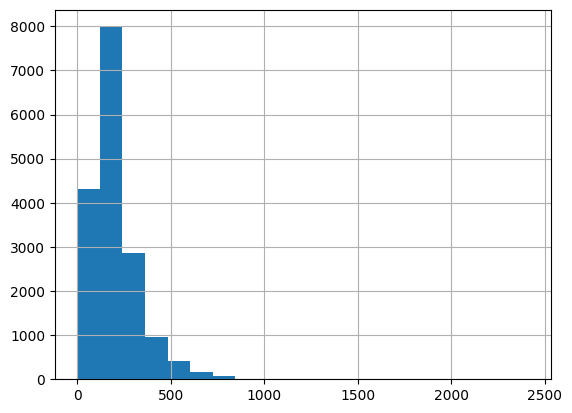

In [7]:
data['word-len'].hist(bins=20)

In [8]:
CUTOFF = int(data['word-len'].mean() + data['word-len'].std())

In [9]:
import re
data['no-punct'] = data['Lyric'].apply(lambda i: re.sub(r'[^\w\s]', '', i))
data['no-punct'] = data['no-punct'].apply(lambda i: i.lower())
data['words-split'] = data['no-punct'].apply(lambda i: re.split(' |\n', i))
data['words-split'] = data['words-split'].apply(lambda i: [j for j in i if j])

In [10]:
data['words-split'].head()

0    [saint, anger, round, my, neck, saint, anger, ...
1    [road, runner, road, runner, going, hundred, m...
2    [come, if, our, own, lives, arent, directly, a...
3    [ayy, yall, heard, about, the, good, news, yal...
4    [ill, never, be, the, same, breaking, decency,...
Name: words-split, dtype: object

In [11]:
# Normalize sequence length
data['trimmed'] = data['words-split'].apply(lambda i: i[:CUTOFF] if len(i) > CUTOFF else i)
data['padded'] = data['trimmed'].apply(lambda i: i + [''] * (CUTOFF - len(i)))

In [12]:
tqdm.pandas()
encodings = np.stack(data['padded'].progress_apply(lambda i: np.stack([vectorize(j) for j in i])))
encodings.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16797/16797 [00:25<00:00, 656.15it/s]


(16797, 329, 302)

## Preprocess Tags

In [13]:
data['seeds'] = data['seeds'].apply(lambda i: eval(i))

In [14]:
data['seeds'].apply(len).mean()

1.4778234208489611

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer
enc = MultiLabelBinarizer()
enc.fit(data['seeds'])
encoded_tags = enc.transform(data['seeds'])

In [16]:
encoded_tags.shape

(16797, 264)

48.0

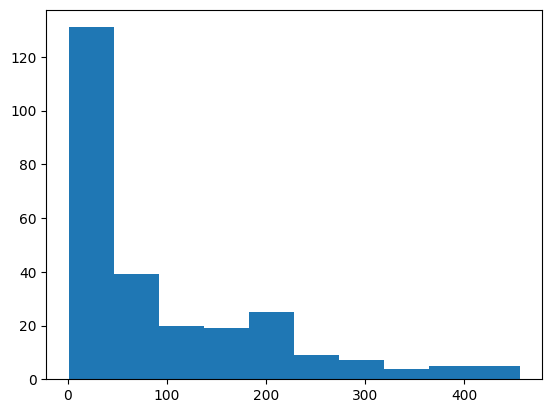

In [17]:
counts = np.sum(encoded_tags, axis=0)

import matplotlib.pyplot as plt
plt.hist(counts)
np.median(counts)

In [22]:
LABEL_FREQ_THRESH = encoded_tags.shape[0] * .02
y_names = enc.classes_[counts >= LABEL_FREQ_THRESH]

In [19]:
indices_to_keep = np.arange(counts.shape[0])[counts >= LABEL_FREQ_THRESH]
encoded_tags_trimmed = encoded_tags[:, indices_to_keep]
encoded_tags_trimmed.shape

(16797, 12)

## Model

In [38]:
import tensorflow as tf

def build_model():
    in_size = 302
    out_size = encoded_tags.shape[1]

    inputs = tf.keras.layers.Input((CUTOFF, in_size))
    x = tf.keras.layers.Dense(10)(inputs)
    # x = tf.keras.layers.Reshape((*x.shape[1:], 1))(x)
    # x = tf.keras.layers.Conv2D(100, 25, activation='relu')(x)
    # x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(out_size, activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=.1)(x)
    # x = tf.keras.layers.Dense(out_size, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [39]:
build_model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 329, 302)]        0         
                                                                 
 dense (Dense)               (None, 329, 10)           3030      
                                                                 
 flatten (Flatten)           (None, 3290)              0         
                                                                 
 dense_1 (Dense)             (None, 264)               868824    
                                                                 
 dropout (Dropout)           (None, 264)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 265       
                                                                 
Total params: 872,119
Trainable params: 872,119
Non-trainable

In [40]:
import imblearn

def validate(model, x_val, y_val):
    orig_shape = x_val.shape
    x_val_flat = x_val.reshape((x_val.shape[0], x_val.shape[1] * x_val.shape[2]))
    under_sampler = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1.0)
    x_val_res, y_val_res = under_sampler.fit_resample(x_val_flat, y_val)
    x_val_res = x_val_res.reshape(x_val_res.shape[0], *orig_shape[1:])
    model.evaluate(x_val_res, y_val_res, batch_size=100)

def train_binary_classifier(orig_shape, flat_encodings, x_val, y, y_val, y_names, batch_size, epochs_per_model, 
                            undersampling_strat, n_jobs):
    # Undersampling
    under_sampler = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=undersampling_strat)
    encodings_res, tags_res = under_sampler.fit_resample(flat_encodings, y)

    # Oversampling
    over_sampler = imblearn.over_sampling.BorderlineSMOTE(sampling_strategy=1.0, n_jobs=n_jobs)
    encodings_res, tags_res = over_sampler.fit_resample(encodings_res, tags_res)

    # Reshape
    encodings_res = encodings_res.reshape(encodings_res.shape[0], *orig_shape[1:])

    model = build_model()
    val_loss_history = []
    for i in range(epochs_per_model):
        print(f'Epoch {i + 1} of {epochs_per_model}:')
        history = model.fit(encodings_res, tags_res, validation_data=(x_val, y_val), batch_size=batch_size, shuffle=True)
        val_loss_history.append(history.history['val_loss'][0])
        if len(val_loss_history) > 1 and val_loss_history[-1] > val_loss_history[-2]:
            print('Early stop point reached!')
            break
        validate(model, x_val, y_val)
    return model

def train_models(x, x_val, y, y_val, y_names):
    orig_shape = x.shape
    flat_encodings = x.reshape((orig_shape[0], orig_shape[1] * orig_shape[2]))
    models = []

    for i in range(y.shape[1]):
        print(f'Training model {i + 1} of {y.shape[1]}:')
        model = train_binary_classifier(orig_shape, flat_encodings, x_val, y[:, i], y_val[:, i], y_names,
                                        batch_size=100, epochs_per_model=25, undersampling_strat=.25, n_jobs=7)
        model.save(f'demo-tags/{y_names[i]}')
        models.append(model)
    return models

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(encodings, encoded_tags_trimmed, test_size=.1)

In [29]:
models = train_models(x_train, x_val, y_train, y_val, y_names)

Training model 1 of 12:


/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1 of 25:


2023-03-08 20:24:25.888895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - ETA: 0s - loss: 0.6281 - accuracy: 0.6478

2023-03-08 20:24:30.788529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 68ms/step - loss: 0.7145 - accuracy: 0.5135
Epoch 2 of 25:
1/1 [==============================] - 0s 35ms/step - loss: 0.9127 - accuracy: 0.5541
Epoch 3 of 25:
1/1 [==============================] - 0s 31ms/step - loss: 1.1861 - accuracy: 0.5135
Epoch 4 of 25:
1/1 [==============================] - 0s 30ms/step - loss: 1.4008 - accuracy: 0.5405
Epoch 5 of 25:
29/29 [==============================] - 2s 73ms/step - loss: 0.0904 - accuracy: 0.9793 - val_loss: 0.3553 - val_accuracy: 0.8643
Early stop point reached!
INFO:tensorflow:Assets written to: demo-tags/angry/assets
Training model 2 of 12:


/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1 of 25:


2023-03-08 20:25:01.724817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.6533

2023-03-08 20:25:04.771903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 71ms/step - loss: 0.9439 - accuracy: 0.5185
Epoch 2 of 25:
25/25 [==============================] - 2s 81ms/step - loss: 0.4356 - accuracy: 0.8091 - val_loss: 0.4413 - val_accuracy: 0.7780
Early stop point reached!
INFO:tensorflow:Assets written to: demo-tags/bittersweet/assets
Training model 3 of 12:


/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1 of 25:


2023-03-08 20:25:21.696391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6252 - accuracy: 0.6444

2023-03-08 20:25:24.041307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 79ms/step - loss: 0.8477 - accuracy: 0.5385
Epoch 2 of 25:
30/30 [==============================] - 2s 72ms/step - loss: 0.4722 - accuracy: 0.7683 - val_loss: 0.5201 - val_accuracy: 0.7101
Early stop point reached!
INFO:tensorflow:Assets written to: demo-tags/dark/assets
Training model 4 of 12:


/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1 of 25:


2023-03-08 20:25:37.530148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.6904

2023-03-08 20:25:40.151337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 69ms/step - loss: 0.8253 - accuracy: 0.5143
Epoch 2 of 25:
28/28 [==============================] - 2s 87ms/step - loss: 0.3879 - accuracy: 0.8472 - val_loss: 0.5983 - val_accuracy: 0.6649
Early stop point reached!
INFO:tensorflow:Assets written to: demo-tags/dreamy/assets
Training model 5 of 12:


/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1 of 25:


2023-03-08 20:25:59.229210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.6006 - accuracy: 0.6620

2023-03-08 20:26:01.661576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 74ms/step - loss: 0.7468 - accuracy: 0.5000
Epoch 2 of 25:
28/28 [==============================] - 2s 77ms/step - loss: 0.3720 - accuracy: 0.8482 - val_loss: 0.4385 - val_accuracy: 0.7690
Early stop point reached!
INFO:tensorflow:Assets written to: demo-tags/epic/assets
Training model 6 of 12:


/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1 of 25:


2023-03-08 20:26:16.558160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - ETA: 0s - loss: 0.6229 - accuracy: 0.6528

2023-03-08 20:26:19.074607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 23ms/step - loss: 0.8661 - accuracy: 0.4375
Epoch 2 of 25:
26/26 [==============================] - 2s 83ms/step - loss: 0.4116 - accuracy: 0.8264 - val_loss: 0.6009 - val_accuracy: 0.6839
Early stop point reached!
INFO:tensorflow:Assets written to: demo-tags/fun/assets
Training model 7 of 12:


/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1 of 25:


2023-03-08 20:26:36.185135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 0.6160 - accuracy: 0.6559

2023-03-08 20:26:38.598190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 78ms/step - loss: 0.8628 - accuracy: 0.4651
Epoch 2 of 25:
1/1 [==============================] - 0s 32ms/step - loss: 1.1915 - accuracy: 0.5233
Epoch 3 of 25:
1/1 [==============================] - 0s 31ms/step - loss: 1.5861 - accuracy: 0.4884
Epoch 4 of 25:
32/32 [==============================] - 3s 79ms/step - loss: 0.1761 - accuracy: 0.9462 - val_loss: 0.5292 - val_accuracy: 0.7679
Early stop point reached!
INFO:tensorflow:Assets written to: demo-tags/happy/assets
Training model 8 of 12:


/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1 of 25:


2023-03-08 20:27:05.277015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - ETA: 0s - loss: 0.6017 - accuracy: 0.6832

2023-03-08 20:27:08.102163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 76ms/step - loss: 0.9895 - accuracy: 0.4189
Epoch 2 of 25:
34/34 [==============================] - 2s 72ms/step - loss: 0.4584 - accuracy: 0.7933 - val_loss: 0.5875 - val_accuracy: 0.6530
Early stop point reached!
INFO:tensorflow:Assets written to: demo-tags/melancholy/assets
Training model 9 of 12:


/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1 of 25:


2023-03-08 20:27:26.091219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - ETA: 0s - loss: 0.6001 - accuracy: 0.6669

2023-03-08 20:27:28.578293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 61ms/step - loss: 0.8936 - accuracy: 0.4444
Epoch 2 of 25:
1/1 [==============================] - 0s 32ms/step - loss: 1.0032 - accuracy: 0.5000
Epoch 3 of 25:
1/1 [==============================] - 0s 28ms/step - loss: 1.4200 - accuracy: 0.4667
Epoch 4 of 25:
33/33 [==============================] - 1s 38ms/step - loss: 0.2305 - accuracy: 0.9132 - val_loss: 0.4979 - val_accuracy: 0.7536
Early stop point reached!
INFO:tensorflow:Assets written to: demo-tags/mellow/assets
Training model 10 of 12:


/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1 of 25:


2023-03-08 20:27:51.315840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.6284 - accuracy: 0.6305

2023-03-08 20:27:54.309636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 108ms/step - loss: 0.7244 - accuracy: 0.5698
Epoch 2 of 25:
1/1 [==============================] - 0s 37ms/step - loss: 0.8049 - accuracy: 0.5814
Epoch 3 of 25:
1/1 [==============================] - 0s 25ms/step - loss: 1.0472 - accuracy: 0.5233
Epoch 4 of 25:
28/28 [==============================] - 1s 40ms/step - loss: 0.1922 - accuracy: 0.9453 - val_loss: 0.5151 - val_accuracy: 0.7577
Early stop point reached!
INFO:tensorflow:Assets written to: demo-tags/romantic/assets
Training model 11 of 12:


/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1 of 25:


2023-03-08 20:28:20.532740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 0.6066 - accuracy: 0.6659

2023-03-08 20:28:23.447306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 90ms/step - loss: 0.8616 - accuracy: 0.5000
Epoch 2 of 25:
32/32 [==============================] - 2s 66ms/step - loss: 0.4036 - accuracy: 0.8214 - val_loss: 0.5561 - val_accuracy: 0.6726
Early stop point reached!
INFO:tensorflow:Assets written to: demo-tags/sad/assets
Training model 12 of 12:


/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1 of 25:


2023-03-08 20:28:41.587895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 0.5843 - accuracy: 0.6756

2023-03-08 20:28:44.342924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 95ms/step - loss: 0.7400 - accuracy: 0.5104
Epoch 2 of 25:
1/1 [==============================] - 0s 126ms/step - loss: 0.9684 - accuracy: 0.5208
Epoch 3 of 25:
32/32 [==============================] - 2s 57ms/step - loss: 0.2315 - accuracy: 0.9266 - val_loss: 0.4535 - val_accuracy: 0.8250
Early stop point reached!
INFO:tensorflow:Assets written to: demo-tags/sexy/assets


In [24]:
import tensorflow as tf
def load_models(y_names):
    return [tf.keras.models.load_model(f'demo-tags/{i}') for i in y_names]

In [47]:
y_names

array(['angry', 'bittersweet', 'dark', 'dreamy', 'epic', 'fun', 'happy',
       'melancholy', 'mellow', 'romantic', 'sad', 'sexy'], dtype=object)

In [25]:
models = load_models(y_names)

Metal device set to: Apple M1 Pro


2023-03-08 22:33:28.911026: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-08 22:33:28.911490: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Validation

In [33]:
prop_ones = encodings.shape[0] * .02
ones = np.ones(int(prop_ones))
zeros = np.zeros(int(encodings.shape[0] - int(prop_ones)))
random_labels = np.concatenate([ones, zeros])
rng = np.random.default_rng()
rng.shuffle(random_labels)  # Generate random array of ones and zeros with correct proportion

In [43]:
from sklearn.model_selection import train_test_split
x_train_bogus, x_val_bogus, y_train_bogus, y_val_bogus = train_test_split(encodings, random_labels, test_size=.1)

In [46]:
result = train_binary_classifier(x_train_bogus.shape, x_train_bogus.reshape(x_train_bogus.shape[0], x_train_bogus.shape[1] * x_train_bogus.shape[2]),
                        x_val_bogus, y_train_bogus, y_val_bogus, y_names, 100, 25, .25, 7)

/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1 of 25:


2023-03-08 22:44:20.850043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.6050

2023-03-08 22:44:22.110328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 55ms/step - loss: 0.7922 - accuracy: 0.4828
Epoch 2 of 25:
1/1 [==============================] - 0s 24ms/step - loss: 1.0457 - accuracy: 0.4655
Epoch 3 of 25:
25/25 [==============================] - 2s 79ms/step - loss: 0.3020 - accuracy: 0.8897 - val_loss: 0.5517 - val_accuracy: 0.7208
Early stop point reached!


In [90]:
y_val.shape

(1680, 12)

In [92]:
mask = y_val[:, 0] == 1

In [79]:
data[data['seeds'].apply(lambda i: 'angry' in i)]['seeds']

4                                    [aggressive, angry]
5                            [aggressive, angry, bitter]
8                [aggressive, angry, driving, energetic]
10                                   [aggressive, angry]
24     [aggressive, angry, cold, fun, gritty, warm, f...
                             ...                        
683                                              [angry]
684                                [angry, wry, lyrical]
685                                   [angry, cathartic]
686                                              [angry]
687                                              [angry]
Name: seeds, Length: 399, dtype: object

In [80]:
test_idx = 4
to_pred = np.stack([vectorize(i) for i in data['padded'].iloc[test_idx]])
to_pred = np.expand_dims(to_pred, axis=0)

In [74]:
data.iloc[test_idx]['seeds']

['aggressive', 'angry']

In [75]:
model.predict(to_pred)[0]

1/1 [==============================] - 0s 15ms/step


array([0.9999521], dtype=float32)

In [129]:
predictions = model.predict(encodings, batch_size=100)

168/168 [==============================] - 2s 11ms/step


In [132]:
predictions[0]

array([0.07613113], dtype=float32)

In [34]:
predictions[:, 0].std(), predictions[:, 1].std(), predictions[:, 2].std()

(7.450581e-09, 7.450581e-09, 7.450581e-09)

In [36]:
# import matplotlib.pyplot as plt

# rng = np.random.default_rng()
# sample = rng.integers(len(data), size=100)

# to_pred = data['padded'].iloc[sample]
# to_pred = np.stack([enc.transform(i) for i in to_pred])
# x = np.stack([i.toarray() for i in to_pred])
# pred = model.predict(x, batch_size=100)
pred = predictions

In [38]:
from sklearn.metrics import r2_score
valence_lbls = data['arousal_norm'].to_numpy()
r2_score(valence_lbls, pred[:, 1])

-0.001694765315293223

Text(0.5, 1.0, 'Valence Prediction Performance')

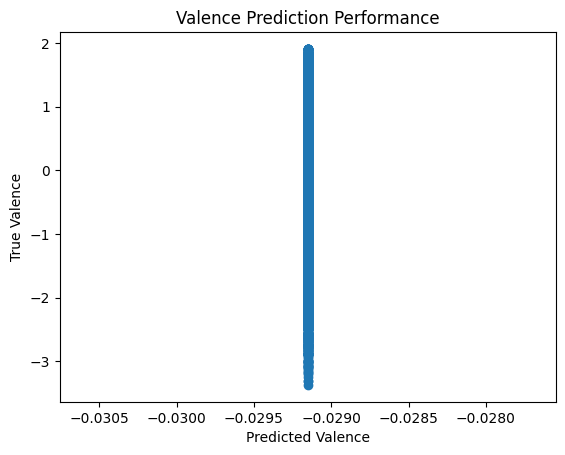

In [39]:
valence_true = data['valence_norm']
valence_pred = pred[:, 0]
plt.scatter(valence_pred, valence_true)
plt.xlabel('Predicted Valence')
plt.ylabel('True Valence')
plt.title('Valence Prediction Performance')

Text(0.5, 1.0, 'Arousal Prediction Performance')

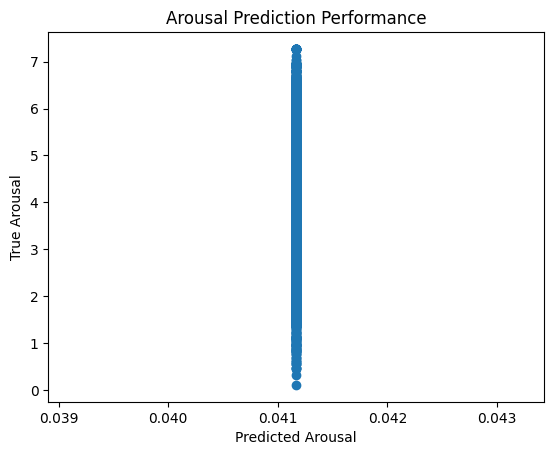

In [40]:
arousal_true = data['arousal_tags']
arousal_pred = pred[:, 1]
plt.scatter(arousal_pred, arousal_true)
plt.xlabel('Predicted Arousal')
plt.ylabel('True Arousal')
plt.title('Arousal Prediction Performance')

Text(0.5, 1.0, 'Dominance Prediction Performance')

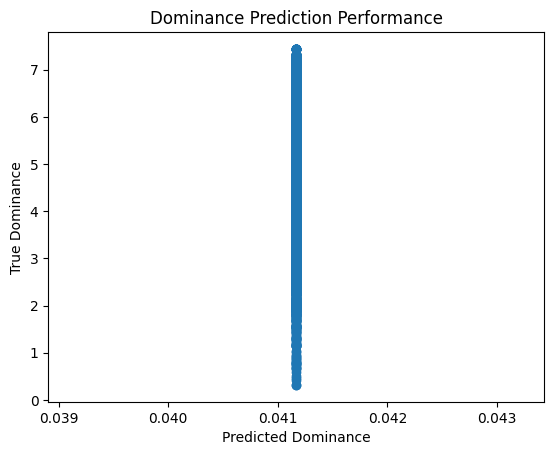

In [41]:
dominance_true = data['dominance_tags']
dominance_pred = pred[:, 2]
plt.scatter(dominance_pred, dominance_true)
plt.xlabel('Predicted Dominance')
plt.ylabel('True Dominance')
plt.title('Dominance Prediction Performance')